# Engine Design Calculations

In [15]:
from matplotlib import pyplot as plt
from lib import cea
from lib.nozzle import *
import numpy as np
from scipy import constants
import thermo
import fluids

## Initial parameters

In [16]:
equilibrium = True

fuel_chems = ('JP-5',) #allows specifying a mixture of chemicals in the fuel
fuel_percs = (100,) #see the CEA docs for which formula strings will work
rho_fuel_kgpm3 = 810
press_chem='N2' #pressurant to use
P_press_initial_bar = 200
T_initial_fuel_K = 298

ox_chem = 'O2'
T_initial_ox_K = 298
P_initial_ox_bar = 200

r_of_mass = 1.85
L_char_m = 1.3 #combustion characteristic length

F_thrust_N = 3000 # thas right.
dt_burn_s = 30 #max. burn time (for test stand run duration)
P_chamber_bar = 30
P_ambient_bar = 1.013

T_std_K = 289 #60degF is standard conditions for finding SCFM flow rate
P_std_bar = 1.013 #1atm is ...
P_fuel_tank_bar = 40

## Combustion analysis

In [17]:
#setup input data
cea_inp = cea.CEAInputData()
cea_inp.equilibrium = equilibrium
cea_inp.fuel_chems = fuel_chems
cea_inp.fuel_chem_mass_percs = fuel_percs
cea_inp.ox_chem = ox_chem
cea_inp.fuel_initial_temp = T_initial_fuel_K
cea_inp.ox_initial_temp = T_initial_ox_K
cea_inp.pcham = P_chamber_bar
cea_inp.pamb = P_ambient_bar
cea_inp.of=r_of_mass

#run CEA
cea.create_inp_file(cea_inp)
cea.run_executable()
out = cea.parse_out_file()

#setup output data
T_chamber_K = out.chamber_temp
v_exhaust_mps = out.exhaust_velocity
c_star_mps = out.cstar
gamma_exhaust = out.exhaust_gamma
M_exhaust_kgpkmol = out.exhaust_molar_mass

print(f'Exhaust speed: {v_exhaust_mps:.1f}m/s (specific impulse of {v_exhaust_mps/9.81:.1f}s)')
print(f'Exhaust properties: gamma={gamma_exhaust}, M={M_exhaust_kgpkmol}kg/kmol')
print(f'Chamber temperature: {T_chamber_K:.1f}K')

Exhaust speed: 2632.3m/s (specific impulse of 268.3s)
Exhaust properties: gamma=1.2455, M=20.277kg/kmol
Chamber temperature: 3207.3K


## Nozzle & chamber

In [18]:
#input parameters
r_A_converging = 8 #converging section area ratio (chamber area / throat area)
theta_diverging_deg = 20
theta_converging_deg = 45

In [19]:
# check CEA values using simpler calc. of performance
R=8.3144e3
R_exhaust_JpkmolK = R / M_exhaust_kgpkmol
v_exhaust_isentropic_mps = exhaust_velocity(
    gamma_exhaust, M_exhaust_kgpkmol, T_chamber_K, P_chamber_bar, P_ambient_bar)
if abs(v_exhaust_isentropic_mps - v_exhaust_mps) > 5:
    print('CEA and isentropic velocity calcs don\'t match. uh oh')
    print(f'Isentropic exhaust vel: {v_exhaust_isentropic_mps} m/s')
else:
    print('CEA and simplified velocity calcs match. good')

NameError: name 'constants' is not defined

In [ ]:
# propellant mass flow rates
m_dot_kgps = F_thrust_N / v_exhaust_mps
m_dot_fuel_kgps = m_dot_kgps / (1 + r_of_mass)
m_dot_ox_kgps = r_of_mass * m_dot_fuel_kgps

print('Propellant flow rates')
print(f'Total: {m_dot_kgps:.3f}kg/s Fuel: {m_dot_fuel_kgps:.3f}kg/s Oxidizer: {m_dot_ox_kgps:.3f}kg/s')


Propellant flow rates
Total: 1.140kg/s Fuel: 0.400kg/s Oxidizer: 0.740kg/s


In [ ]:
# engine cross-sectional areas
r_A_diverging = expansion_ratio(gamma_exhaust, P_chamber_bar, P_ambient_bar)
A_throat_m2 = throat_area(gamma_exhaust, M_exhaust_kgpkmol, m_dot_kgps, T_chamber_K, P_chamber_bar)
A_exit_m2 = A_throat_m2 * r_A_diverging
A_chamber_m2 = A_throat_m2 * r_A_converging

def radius(area):
    return np.sqrt(area / np.pi)

# engine dimensions
r_chamber_m = radius(A_chamber_m2)
r_throat_m = radius(A_throat_m2)
r_exit_m = radius(A_exit_m2)

print(f'Chamber radius: {r_chamber_m*1000:.1f}mm. Throat: {r_throat_m*1e3:.1f}mm. Exit: {r_exit_m*1e3:.1f}mm')

L_diverging_m = cone_length(r_throat_m, r_exit_m, theta_diverging_deg)
L_converging_m = cone_length(r_throat_m, r_chamber_m, theta_converging_deg)

print(f'Converging length: {L_converging_m*1e3:.1f}mm. Diverging: {L_diverging_m*1e3:.1f}mm.')

V_chamber_m3 = A_throat_m2 * L_char_m
L_chamber_m = chamber_length(V_chamber_m3, L_converging_m, A_chamber_m2, A_throat_m2)

print(f'Chamber volume for given characteristic length: {V_chamber_m3*1e6:.1f}cm^3')
print(f'Chamber length: {L_chamber_m*1e3:.1f}mm')

Chamber radius: 41.1mm. Throat: 14.5mm. Exit: 30.8mm
Converging length: 26.6mm. Diverging: 44.6mm.
Chamber volume for given characteristic length: 861.8cm^3
Chamber length: 123.2mm


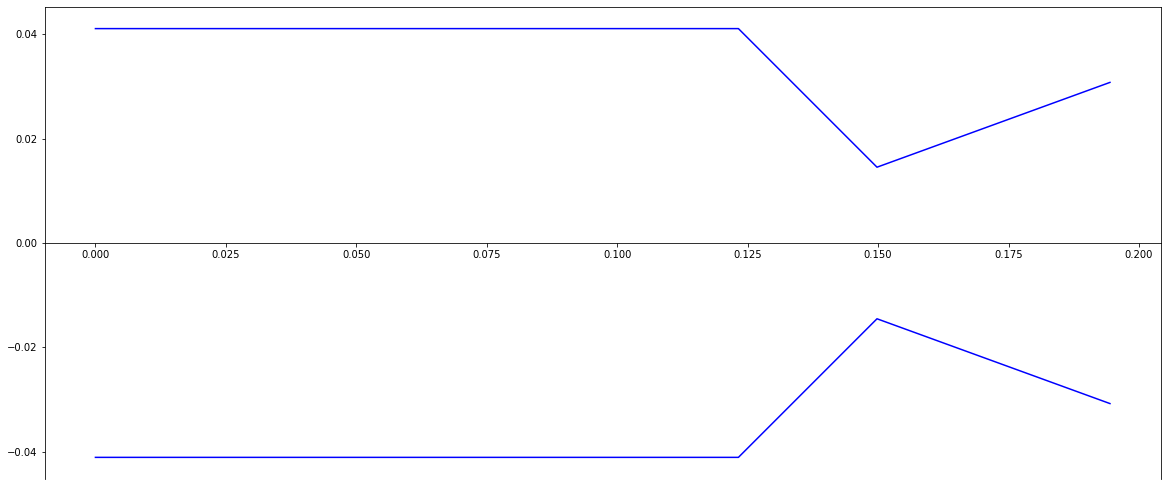

In [ ]:
# draw nozzle diagram to give an idea of proportions
%matplotlib inline
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot()
pts=[(0,r_chamber_m), (L_chamber_m,r_chamber_m), (L_chamber_m+L_converging_m,r_throat_m), (L_chamber_m+L_converging_m+L_diverging_m, r_exit_m)]
xs, ys = zip(*pts)
neg_ys = [-y for y in ys]
ax.set_aspect('equal', 'box')
ax.spines.bottom.set_position('zero')
ax.plot(xs,ys,'b',xs,neg_ys,'b')

## Injector

In [ ]:
#input parameters
dP_injector_ox_bar = 5 #pressure drop in ox. inj.
Cd_injector_ox = 0.7 #discharge coefficient in ox inj.
n_injectors_ox = 8

dP_injector_fuel_bar = 5

In [ ]:
def injector_area(mdot, Cd, rho, delta_P):
    '''returns total area of injector required to achieve a given mass flow rate,
    given Cd for injector, density of fuel, and pressure drop across injector.
    assumes incompressible fluid flow through a hydraulic orifice (perhaps unreasonable for our oxidiser, GOX...)'''
    return mdot / Cd / np.sqrt(2 * rho * delta_P * 1e5)

In [ ]:
# fuel injector
# fuel volume flow rate, used to pick a spray nozzle part
V_dot_fuel_m3ps = m_dot_fuel_kgps / rho_fuel_kgpm3
P_fuel_injector_bar = P_chamber_bar + dP_injector_fuel_bar
print(f'Fuel volume flow rate: {V_dot_fuel_m3ps*1e3:.3f}L/s')


Fuel volume flow rate: 0.494L/s


In [ ]:
# oxidiser injector
# lookup oxidiser density at injector inlet using CoolProp
ox = thermo.chemical.Chemical(ox_chem)
ox.calculate(T=T_initial_ox_K, P=P_chamber_bar*constants.bar)
rho_ox_chamber_kgpm3 = ox.rho
ox.calculate(T=T_initial_ox_K, P=P_initial_ox_bar*constants.bar)
rho_ox_tank_kgpm3 = ox.rho
ox.calculate(T=T_initial_ox_K, P=P_std_bar*constants.bar)
rho_ox_std_kgpm3 = ox.rho

P_ox_injector_bar = P_chamber_bar + dP_injector_ox_bar

V_dot_injector_ox_m3ps = m_dot_ox_kgps / rho_ox_chamber_kgpm3
V_dot_tank_ox_m3ps = m_dot_ox_kgps/rho_ox_tank_kgpm3
print(f'Oxidiser volume flow rate: {V_dot_injector_ox_m3ps*1e3:.3f}L/s ({V_dot_tank_ox_m3ps*1e3:.3f}L/s exiting tank)')
V_dot_ox_stdft3ps = (m_dot_ox_kgps / rho_ox_std_kgpm3) / constants.foot**3
print(f'Oxidiser flow, std. ft^3/s: {V_dot_ox_stdft3ps:.1f}')

# injector area
A_injector_ox_m2 = injector_area(
    m_dot_ox_kgps,
    Cd_injector_ox,
    rho_ox_chamber_kgpm3,
    dP_injector_ox_bar)
print(f'Total ox. injector area: {A_injector_ox_m2*1e4:.2f}cm^2')
r_injector_ox_m = np.sqrt(A_injector_ox_m2/np.pi/n_injectors_ox)
print(f'Radius of the {n_injectors_ox} ox. injectors: {r_injector_ox_m*1e3:.2f}mm')

Oxidiser volume flow rate: 18.607L/s (2.650L/s exiting tank)
Oxidiser flow, std. ft^3/s: 20.0
Total ox. injector area: 1.68cm^2
Radius of the 8 ox. injectors: 2.58mm


## Propellant tanks

In [ ]:
V_cylinder_stdft3 = 250
#volume of a K size cylinder, standard cubic feet (SCF)
# (specified by the volume of the gas contained if it were at standard conditions)

m_fuel_kg = m_dot_fuel_kgps * dt_burn_s
print(f'{dt_burn_s}s burn consumes {m_fuel_kg:.1f}kg fuel.')

V_fuel_tank_m3 = V_dot_fuel_m3ps * dt_burn_s
print(f'Volume of fuel consumed: {V_fuel_tank_m3*1e3:.1f}L')

press = thermo.chemical.Chemical(press_chem)
press.calculate(T=T_std_K, P=P_std_bar * constants.bar)
rho_press_std_kgpm3 = press.rho
press.calculate(T=T_initial_fuel_K, P=P_fuel_tank_bar * constants.bar)
rho_press_tank_kgpm3 = press.rho

V_dot_press_stdft3ps = V_dot_fuel_m3ps * rho_press_tank_kgpm3 / rho_press_std_kgpm3 \
    / constants.foot**3
V_press_stdft3 = V_dot_press_stdft3ps * dt_burn_s

print(f'Presurant flow is {V_dot_press_stdft3ps:.2f} SCF/s, total of {V_press_stdft3:.1f} SCF consumed ({V_press_stdft3/V_cylinder_stdft3:.0%} of a {V_cylinder_stdft3}SCF cylinder)')

30s burn consumes 12.0kg fuel.
Volume of fuel consumed: 14.8L
Presurant flow is 0.68 SCF/s, total of 20.3 SCF consumed (8% of a 250SCF cylinder)


In [ ]:
m_ox_kg = m_dot_ox_kgps * dt_burn_s
print(f'{dt_burn_s}s burn consumes {m_ox_kg:.1f}kg oxidizer.')
V_ox_tank_m3 = V_dot_tank_ox_m3ps * dt_burn_s
print(f'(approx.) Oxidiser tank volume: {V_ox_tank_m3*1e3:.1f}L')
V_ox_stdft3=V_dot_ox_stdft3ps*dt_burn_s
print(f'Oxidiser tank SCF (std. ft^3): {V_ox_stdft3:.1f}')
print(f'Requires {V_ox_stdft3/V_cylinder_stdft3:.1f}x {V_cylinder_stdft3}SCF cylinders')

30s burn consumes 22.2kg oxidizer.
(approx.) Oxidiser tank volume: 79.5L
Oxidiser tank SCF (std. ft^3): 598.5
Requires 2.4x 250SCF cylinders


## Valves

In [ ]:
# Main fuel valve
P1 = P_fuel_tank_bar*constants.bar  # before valve
P2 = P_fuel_injector_bar*constants.bar  # after valve

# approx. fuel with gasoline (octane) for now
# approx. pressure in valve as midway between pressure before and after valve
fuel = thermo.chemical.Chemical('C8H18', T=T_initial_fuel_K, P=(P1+P2)/2)
Cv_main_fuel = fluids.Kv_to_Cv(fluids.size_control_valve_l(rho=rho_fuel_kgpm3,
                                                           Psat=fuel.Psat,
                                                           Pc=fuel.Pc,
                                                           mu=fuel.mu,
                                                           P1=P1,
                                                           P2=P2,
                                                           Q=V_dot_fuel_m3ps))
print(f'Min. Cv for main fuel valve: {Cv_main_fuel:.2f}')

# Main oxidiser valve
P1 = P_initial_ox_bar*constants.bar
P2 = P_ox_injector_bar*constants.bar

frac_dP_ox_valve = 0.5 #how much of pressure drop from tank to injector occurs in ox valve?
P2 += (P1-P2) * (1-frac_dP_ox_valve)

ox.calculate(T=T_initial_ox_K, P=(P1+P2)/2)
Cv_main_ox = fluids.Kv_to_Cv(fluids.size_control_valve_g(T=T_initial_ox_K,
                                                         MW=ox.MW,
                                                         mu=0, # thermo lib won't give a viscosity for ideal gas?
                                                         gamma=ox.isentropic_exponent,
                                                         Z=ox.Z,
                                                         P1=P1,
                                                         P2=P2,
                                                         Q=V_dot_ox_stdft3ps * (constants.foot**3)))

print(f'for main ox valve: {Cv_main_ox:.2f}')




Min. Cv for main fuel valve: 0.83
for main ox valve: 0.87


## Piping

In [ ]:
#rough calculation of piping diameter required

fluids.isothermal_gas(rho=rho_ox_tank_kgpm3, P1=P_initial_ox_bar, P2=P)

NameError: name 'P' is not defined